# 2nd Level Model Structure: Reactive Stage

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pyomo import environ as pe
from global_sets.component import m
from utility.display_utility import trans_product_mole, trans_product_mass
from utility.model_utility import add_dual, update_dual, check_DOF

# stage construction rules
from physics.kinetics.kinetics_reactive import kinetic_block_rule
from physics.energy.energy_reactive import energy_block_rule
from physics.VLE.VLE_reactive import VLE_block_rule

model = pe.ConcreteModel()

# Global Sets (Inlet / Outlet)

In [3]:
model.inlet = pe.Set(initialize=['in'])
model.outlet = pe.Set(initialize=['out','P'])
model.stream = model.inlet | model.outlet

# Global Variables

In [4]:
# Tray Inlet/Outlet Variable
model.x_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.x = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.z = pe.Var(m.COMP_FEED,within=pe.NonNegativeReals)

model.L = pe.Var(model.stream,within=pe.NonNegativeReals)
model.V = pe.Var(model.stream,within=pe.NonNegativeReals)
model.F = pe.Var(within=pe.NonNegativeReals)

model.H_L_ = pe.Var(model.inlet,within=pe.Reals)
model.H_V_ = pe.Var(model.inlet,within=pe.Reals)
model.H_L = pe.Var(within=pe.Reals)
model.H_V = pe.Var(within=pe.Reals)
model.H_F = pe.Var(within=pe.Reals)

# State Variable
model.T = pe.Var(within=pe.NonNegativeReals,bounds=(100+273.15,300+273.15)) # K
model.T_F = pe.Var(within=pe.NonNegativeReals) # K
model.P = pe.Var(within=pe.NonNegativeReals,bounds=(10,30)) # Bar

model.f_V = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)
model.f_L = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)

model.cat = pe.Var(within=pe.NonNegativeReals) # kg
model.Q_main = pe.Var(within=pe.Reals) # MW
model.r_total_comp = pe.Var(m.COMP_TOTAL,within=pe.Reals) # kmol/s

# Construct Individual Blocks

In [5]:
model.kinetics_block = pe.Block(rule=kinetic_block_rule)

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| kinetics_block.k_FT
| kinetics_block.r_FT_total
| kinetics_block.g0_FT
| kinetics_block.alpha
| kinetics_block.r_FT_cnum
| kinetics_block.r_FT_comp
| kinetics_block.k_WGS
| kinetics_block.Ke_WGS
| kinetics_block.r_WGS
| kinetics_block.r_WGS_comp
--------------------------------------------------



In [6]:
model.energy_block = pe.Block(rule=energy_block_rule)

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| energy_block.dH_F
| energy_block.dH_V
| energy_block.dH_L
| energy_block.dH_vap
--------------------------------------------------



In [7]:
model.VLE_block = pe.Block(rule=VLE_block_rule)

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| VLE_block.n_ave
| VLE_block.n_ave_cal
| VLE_block.Hen
| VLE_block.Hen0
| VLE_block.gamma
| VLE_block.P_sat
| VLE_block.P_sat_Y
| VLE_block.P_sat_dY_inf
| VLE_block.P_sat_dY0
| VLE_block.Hen_ref
| VLE_block.Hen0_ref
| VLE_block.gamma_ref
| VLE_block.V_L
| VLE_block.V_L_dY_inf
| VLE_block.V_L_dY0
| VLE_block.poynting
--------------------------------------------------



# Standard MESH Equations

## Mass Balance

\begin{equation}
Fz_{i}+\sum_{s\in{inlet}}L_{s}x'_{i,s}+\sum_{s\in{inlet}}V_{s}y'_{i,s}-\sum_{s\in{outlet}}L_{s}x_{i,s}+\sum_{s\in{ouelet}}V_{s}y_{i,s}+R_{i} = 0 \\
i = 1,...NC
\end{equation}

In [8]:
def mass_balance_main_rule(model,i):
    if i in m.COMP_FEED:
        return model.F*model.z[i] + sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
    else:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
model.mass_balance_main_con = pe.Constraint(m.COMP_TOTAL,rule=mass_balance_main_rule)

## Equilibrium

\begin{align}
&f_{i,V} = f_{i,L} \\
&i = 1,...NC
\end{align}

In [9]:
def VL_equil_rule(model,i):
    return model.f_V[i] == model.f_L[i]
model.VL_equil_con = pe.Constraint(m.COMP_TOTAL,rule=VL_equil_rule)

## Summation

\begin{equation}
\sum_ix_{i} = \sum_iy_{i} \\
F + L_{in} + V_{in} + R = L_{out} + V_{out}
\end{equation}

In [10]:
def summation_x_y_rule(model):
    return sum(model.x[i] for i in m.COMP_TOTAL) == sum(model.y[i] for i in m.COMP_TOTAL)
model.summation_x_y_con = pe.Constraint(rule=summation_x_y_rule)

def summation_total_mass_rule(model):
    return model.F + sum(model.L[s] + model.V[s] for s in model.inlet) + sum(model.r_total_comp[i] for i in m.COMP_TOTAL)\
            - sum(model.L[s] + model.V[s] for s in model.outlet) == 0
model.summation_total_mass_con = pe.Constraint(rule=summation_total_mass_rule)

## Energy Balance

\begin{equation}
F H_f+\sum_{s\in{inlet}}L_{s}H_{l,s}+\sum_{s\in{inlet}}V_{s}H_{v,s}-\sum_{s\in{outlet}}L_{s}H_{l,s}-\sum_{s\in{outlet}}V_{s}H_{v,s}+Q = 0
\end{equation}

In [11]:
def heat_balance_main_rule(model):
    return model.F*model.H_F + sum(model.L[s]*model.H_L_[s] + model.V[s]*model.H_V_[s] for s in model.inlet) \
            + model.Q_main - sum(model.L[s]*model.H_L + model.V[s]*model.H_V for s in model.outlet) == 0
model.heat_balance_main_con = pe.Constraint(rule=heat_balance_main_rule)

# Testing

In [12]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


## Fixing In/Product Redundent Flow

In [13]:
model.x_.fix(0)
model.y_.fix(0)
model.L['in'].fix(0)
model.L['P'].fix(0)
model.V['in'].fix(0)
model.V['P'].fix(0)
model.H_L_.fix(0)
model.H_V_.fix(0)

## Fixing Model Parameters

In [14]:
model.cat.fix(3000)
model.P.fix(20)
model.T_F.fix(200+273.15)
model.F.fix(1)
model.z['CO'].fix(1/(1+0.8)-0.01/2)
model.z['H2'].fix(0.8/(1+0.8)-0.01/2)
model.z['C30H62'].fix(0.01)
model.VLE_block.n_ave.fix(20)

In [15]:
check_DOF(pe,model)

Active Equality Constraints:	 1181
Active Inequality Constraints:	 0
Active Variables:		 1354
Fixed Variables:		 172
DOF:				 1


## Fix T or to fix Q? we have found that Maximize against an upper bound is most reliable

In [16]:
model.T.setub(200+273.15)

In [17]:
# model.obj = pe.Objective(expr = model.L['out'],sense=pe.maximize)
# model.obj = pe.Objective(expr = model.Q_main,sense=pe.maximize)
model.obj = pe.Objective(expr = model.T,sense=pe.maximize)

In [18]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
opt.options['linear_solver'] = 'ma86'

opt.options['linear_system_scaling '] = 'mc19'
opt.options['linear_scaling_on_demand '] = 'no'
# opt.options['recalc_y'] = 'yes'
# opt.options['bound_relax_factor'] = 0
# opt.options['halt_on_ampl_error'] = 'yes'

opt.options['max_iter'] = 7000
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.8: print_user_options=yes
linear_solver=ma86
linear_system_scaling =mc19
linear_scaling_on_demand =no
max_iter=7000


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with

  76 -4.7314985e+02 5.24e-09 8.10e-06  -3.8 1.48e-02    -  1.00e+00 1.00e+00h  1
  77 -4.7315000e+02 7.77e-09 2.41e-03  -5.7 1.80e-02    -  1.00e+00 1.00e+00f  1
  78 -4.7315000e+02 1.35e-10 9.42e-11  -5.7 5.06e-05    -  1.00e+00 1.00e+00h  1
  79 -4.7315000e+02 1.33e-10 3.73e-07  -8.6 2.24e-04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -4.7315000e+02 2.69e-10 2.51e-14  -8.6 7.80e-09    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:  -4.7315000472899408e+02   -4.7315000472899408e+02
Dual infeasibility......:   2.5091040356528538e-14    2.5091040356528538e-14
Constraint violation....:   2.6905079737477716e-10    2.6905079737477716e-10
Complementarity.........:   2.5059035596806412e-09    2.5059035596806412e-09
Overall NLP error.......:   2.5059035596806412e-09    2.5059035596806412e-09


Number of objective funct

In [19]:
model.Q_main.value

-45.26995991699208

In [20]:
model.T.value

473.15

In [21]:
# model.solutions.store_to(results)
# with open('../saved_solutions/reactive_flash_350C_n20.pickle','wb') as f:
#     pickle.dump(results,f)

In [22]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}\t\t\tlog K'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}\t\t\t{:.4f}'.format(model.x[i].value,model.y[i].value,np.log10(model.y[i].value/model.x[i].value)))

Component		Liquid: 0.0197			Vapor: 0.5187			log K
------------------------------------------------------------------------------------------------------------
H2         		 0.8750%			25.0416%			1.4567
CO         		 1.3345%			28.5738%			1.3307
CO2        		 3.7740%			32.2862%			0.9322
H2O        		 3.6365%			12.5211%			0.5370
C2H4       		 0.0176%			 0.1188%			0.8302
C3H6       		 0.0448%			 0.1363%			0.4829
C4H8       		 0.0459%			 0.1213%			0.4221
C5H10      		 0.0720%			 0.0929%			0.1104
C6H12      		 0.1240%			 0.0850%			-0.1641
C7H14      		 0.1993%			 0.0766%			-0.4151
C8H16      		 0.3016%			 0.0675%			-0.6499
C9H18      		 0.4310%			 0.0577%			-0.8729
C10H20     		 0.5802%			 0.0475%			-1.0869
C11H22     		 0.4681%			 0.0238%			-1.2939
C12H24     		 0.5575%			 0.0178%			-1.4952
C13H26     		 0.6275%			 0.0128%			-1.6918
C14H28     		 0.6729%			 0.0088%			-1.8847
C15H30     		 0.6941%			 0.0058%			-2.0743
C16H32     		 0.6954%			 0.0038%			-2.2611
C17H34     		 0.6823%			 0.0024%

# Iterative Solve for Data Analysis

In [23]:
update_dual(pe,model)

In [24]:
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [25]:
rf_data = {}
rf_data['r'] = {}; rf_data['T'] = []; rf_data['Q'] = []; rf_data['V'] = []; rf_data['L'] = []; 
rf_data['y_CO'] = []; rf_data['y_H2'] = []; rf_data['y_CO2'] = []; rf_data['y_H2O'] = []; rf_data['r_WGS'] = []; rf_data['r_FT'] = []
rf_data['f_V_CO'] = []; rf_data['f_V_H2'] = [];

for i in model.r_total_comp:
    rf_data['r'][i] = []
    
Trange = np.arange(300+273.15,99+273.15,-2)

for Tub in Trange:
    model.T.setub(Tub)
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    # print('-'*72)
    print('Solved, Solution T = {:.2f} K\t|\tV = {:.5f}\t|\tL = {:.5f}\t|'.format(model.T.value,model.V['out'].value,model.L['out'].value))
    # print('-'*72)
    rf_data['T'].append(model.T.value)
    rf_data['Q'].append(model.Q_main.value)
    rf_data['V'].append(model.V['out'].value)
    rf_data['L'].append(model.L['out'].value)    

    for i in model.r_total_comp:
        rf_data['r'][i].append(model.r_total_comp[i].value)
    
    
    rf_data['y_H2O'].append(model.y['H2O'].value)
    rf_data['y_CO'].append(model.y['CO'].value)
    rf_data['y_H2'].append(model.y['H2'].value)
    rf_data['y_CO2'].append(model.y['CO2'].value)
    rf_data['r_WGS'].append(model.kinetics_block.r_WGS.value)
    rf_data['r_FT'].append(model.kinetics_block.r_FT_total.value)
    
    rf_data['f_V_CO'].append(model.f_V['CO'].value)
    rf_data['f_V_H2'].append(model.f_V['H2'].value)

Solved, Solution T = 573.15 K	|	V = 0.45303	|	L = 0.01017	|
Solved, Solution T = 571.15 K	|	V = 0.45153	|	L = 0.01029	|
Solved, Solution T = 569.15 K	|	V = 0.45000	|	L = 0.01040	|
Solved, Solution T = 567.15 K	|	V = 0.44843	|	L = 0.01051	|
Solved, Solution T = 565.15 K	|	V = 0.44681	|	L = 0.01062	|
Solved, Solution T = 563.15 K	|	V = 0.44516	|	L = 0.01072	|
Solved, Solution T = 561.15 K	|	V = 0.44347	|	L = 0.01083	|
Solved, Solution T = 559.15 K	|	V = 0.44174	|	L = 0.01093	|
Solved, Solution T = 557.15 K	|	V = 0.43998	|	L = 0.01103	|
Solved, Solution T = 555.15 K	|	V = 0.43817	|	L = 0.01114	|
Solved, Solution T = 553.15 K	|	V = 0.43632	|	L = 0.01124	|
Solved, Solution T = 551.15 K	|	V = 0.43444	|	L = 0.01135	|
Solved, Solution T = 549.15 K	|	V = 0.43252	|	L = 0.01147	|
Solved, Solution T = 547.15 K	|	V = 0.43057	|	L = 0.01159	|
Solved, Solution T = 545.15 K	|	V = 0.42858	|	L = 0.01172	|
Solved, Solution T = 543.15 K	|	V = 0.42657	|	L = 0.01186	|
Solved, Solution T = 541.15 K	|	V = 0.42

## Some Observations

* This system has multiple solution under same Q.
* The reaction rate peaks at ~530K, due to decreasing $\alpha$, increasing light component, uses up more feed.
* Note that when 'fully' utilizing catalyst, the system seems to always require cooling.

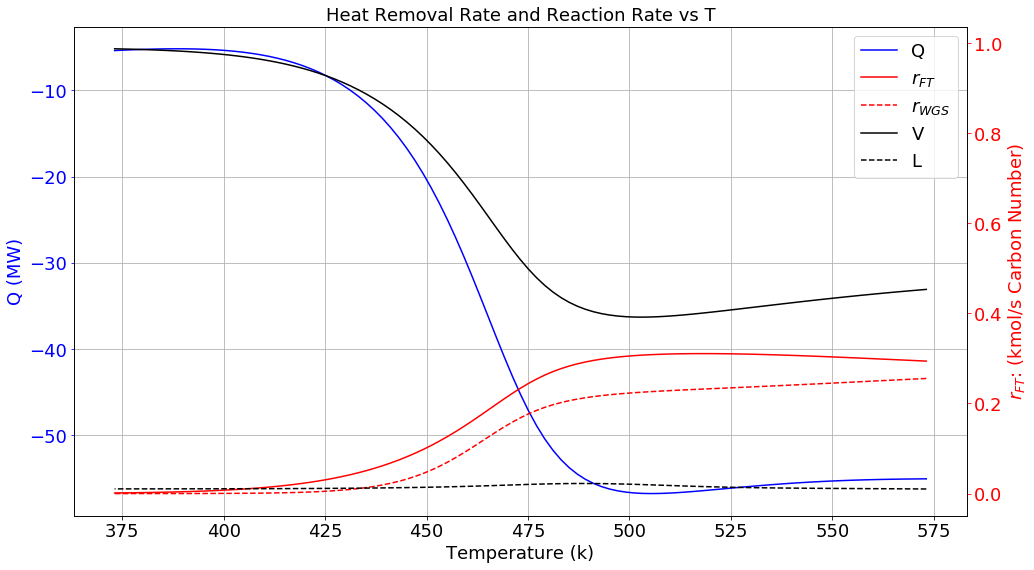

In [26]:
fig, ax1 = plt.subplots(figsize=(16,9))
line1 = ax1.plot(rf_data['T'],rf_data['Q'], 'b-')
ax1.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax1.set_ylabel('Q (MW)', color='b',fontsize=18)
ax1.tick_params('y', colors='b',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line2 = ax2.plot(rf_data['T'],rf_data['r_FT'], 'r')
line3 = ax2.plot(rf_data['T'],rf_data['r_WGS'], 'r--')
line4 = ax2.plot(rf_data['T'],rf_data['V'], 'k')
line5 = ax2.plot(rf_data['T'],rf_data['L'], 'k--')
ax2.set_ylabel('$r_{FT}$: (kmol/s Carbon Number)', color='r',fontsize=18)
ax2.tick_params('y', colors='r',labelsize=18)

ax1.legend(line1+line2+line3+line4+line5,['Q','$r_{FT}$','$r_{WGS}$','V','L'],fontsize=18,loc=1)
ax1.set_title('Heat Removal Rate and Reaction Rate vs T',fontsize=18)
plt.show()

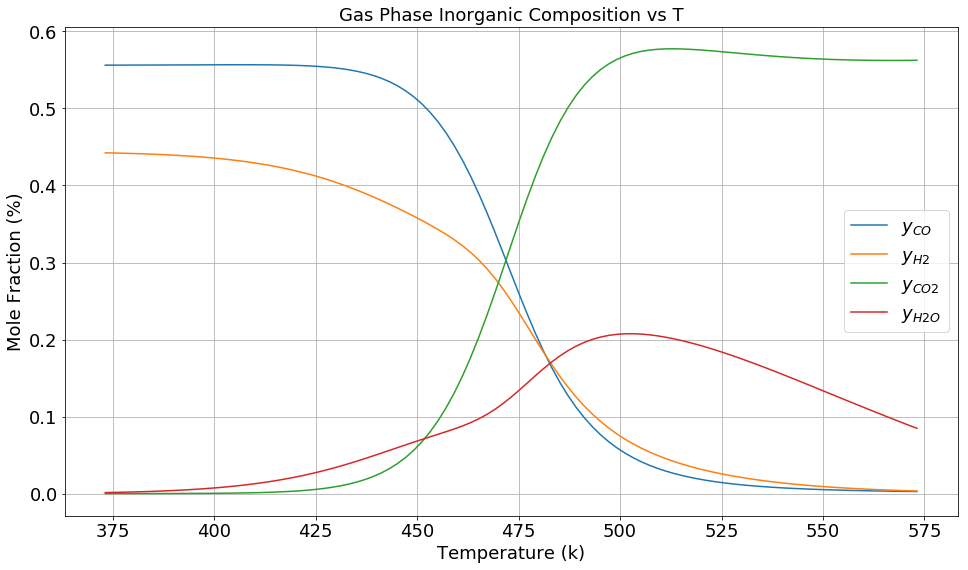

In [27]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['y_CO'])
ax.plot(rf_data['T'],rf_data['y_H2'])
ax.plot(rf_data['T'],rf_data['y_CO2'])
ax.plot(rf_data['T'],rf_data['y_H2O'])

ax.legend(['$y_{CO}$','$y_{H2}$','$y_{CO2}$','$y_{H2O}$'],fontsize=18)
ax.set_title('Gas Phase Inorganic Composition vs T',fontsize=18)

ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

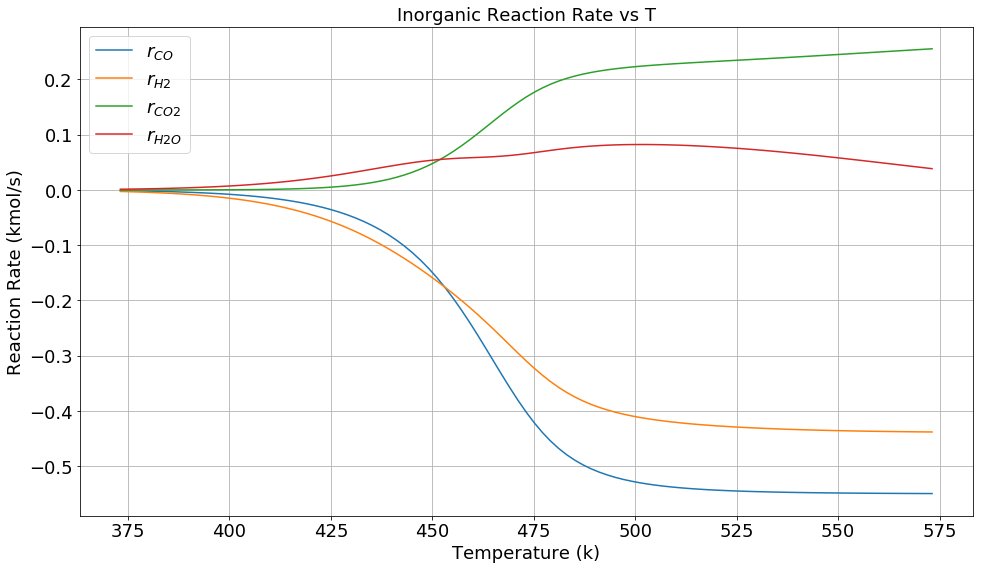

In [28]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['r']['CO'])
ax.plot(rf_data['T'],rf_data['r']['H2'])
ax.plot(rf_data['T'],rf_data['r']['CO2'])
ax.plot(rf_data['T'],rf_data['r']['H2O'])

ax.legend(['$r_{CO}$','$r_{H2}$','$r_{CO2}$','$r_{H2O}$'],fontsize=18)
ax.set_title('Inorganic Reaction Rate vs T',fontsize=18)

ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

## Product Distribution (mole)

In [29]:
reaction_data = trans_product_mole(rf_data['r'])['unscaled']
reaction_data_scaled = trans_product_mole(rf_data['r'])['scaled']

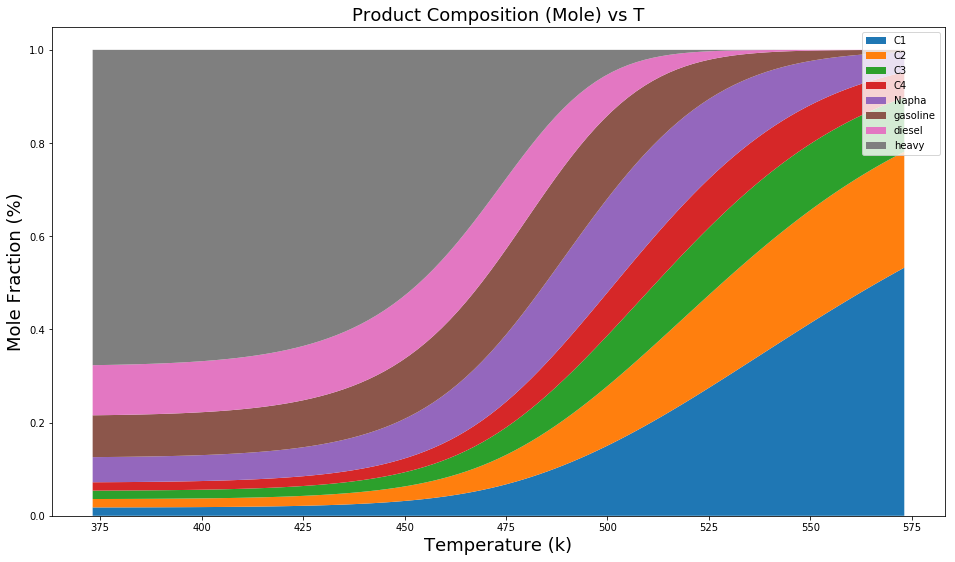

In [30]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], reaction_data_scaled['c1'], reaction_data_scaled['c2'],reaction_data_scaled['c3'],reaction_data_scaled['c4'],\
            reaction_data_scaled['napha'],reaction_data_scaled['gasoline'],reaction_data_scaled['diesel'],reaction_data_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mole) vs T',fontsize=18)
ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

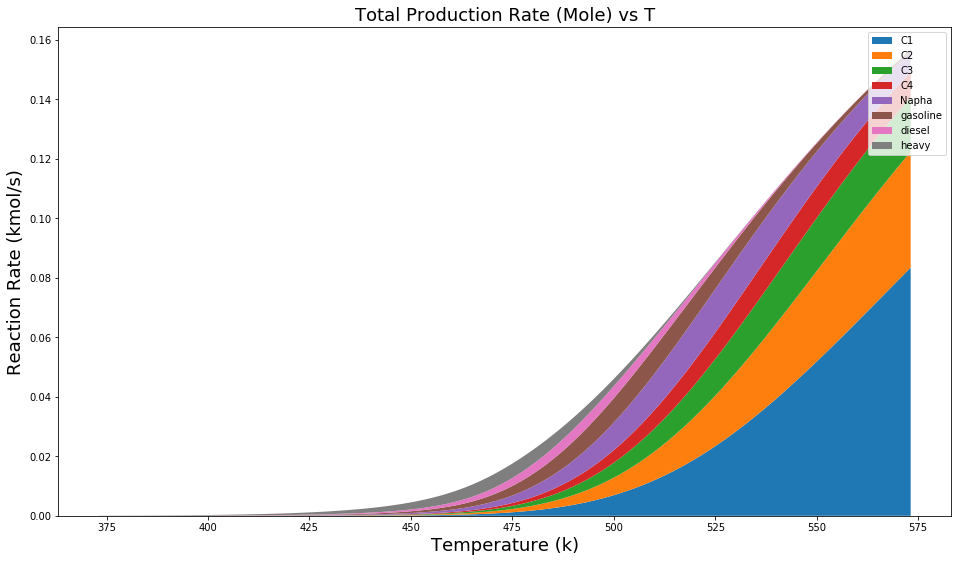

In [31]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], reaction_data['c1'], reaction_data['c2'],reaction_data['c3'],reaction_data['c4'],\
            reaction_data['napha'],reaction_data['gasoline'],reaction_data['diesel'],reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Total Production Rate (Mole) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

## Product Distribution (mass)

In [32]:
mass_reaction_data = trans_product_mass(rf_data['r'])['unscaled']
mass_reaction_scaled = trans_product_mass(rf_data['r'])['scaled']

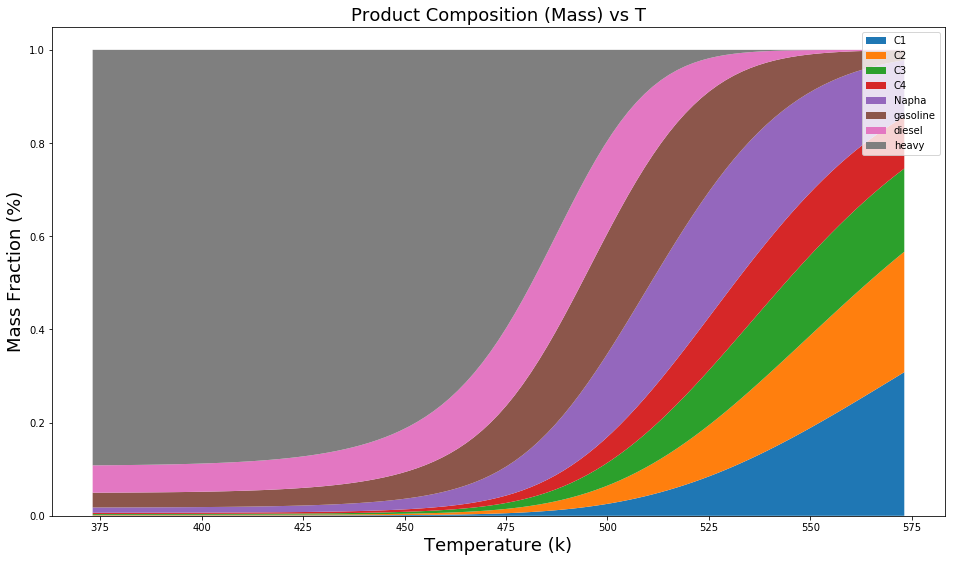

In [33]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], mass_reaction_scaled['c1'], mass_reaction_scaled['c2'],mass_reaction_scaled['c3'],mass_reaction_scaled['c4'],\
            mass_reaction_scaled['napha'],mass_reaction_scaled['gasoline'],mass_reaction_scaled['diesel'],mass_reaction_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mass) vs T',fontsize=18)
ax.set_ylabel('Mass Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

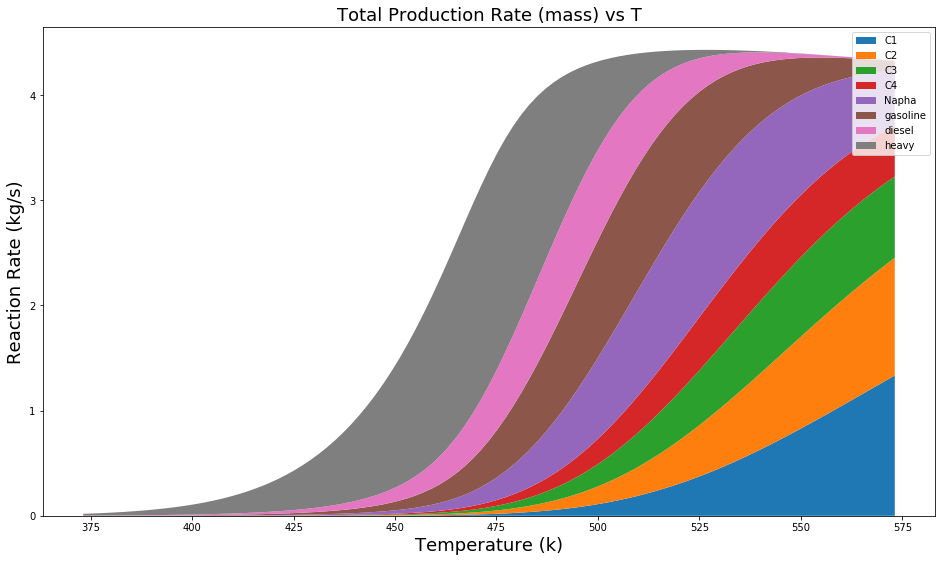

In [34]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], mass_reaction_data['c1'], mass_reaction_data['c2'],mass_reaction_data['c3'],mass_reaction_data['c4'],\
            mass_reaction_data['napha'],mass_reaction_data['gasoline'],mass_reaction_data['diesel'],mass_reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Total Production Rate (mass) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kg/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

In [35]:
# model.solutions.store_to(results)
# with open('../saved_solutions/reactive_flash_200C_n58.pickle','wb') as f:
#     pickle.dump(results,f)

# VLE Validation using AspenPlus

### Feed (Reactor Effluent)

In [36]:
print('Temperature (C): \t{:.2f}\t\t'.format(model.T.value-273.15))
print('Conversion(H2+CO): \t{:.2f}\t\t'.format(1-((model.y['CO'].value+model.y['H2'].value)*model.V['out'].value)))
print('Total FLow (kmol/s): \t{:.2f}\t\t'.format(model.L['out'].value+model.V['out'].value))
print('-'*72)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:.4%}'.format((model.x[i].value*model.L['out'].value\
        +model.y[i].value*model.V['out'].value)/(model.L['out'].value+model.V['out'].value)))

Temperature (C): 	100.00		
Conversion(H2+CO): 	0.01		
Total FLow (kmol/s): 	1.00		
------------------------------------------------------------------------
H2         		43.7909%
CO         		55.0673%
CO2        		0.0014%
H2O        		0.1330%
C2H4       		0.0001%
C3H6       		0.0001%
C4H8       		0.0001%
C5H10      		0.0001%
C6H12      		0.0001%
C7H14      		0.0001%
C8H16      		0.0001%
C9H18      		0.0001%
C10H20     		0.0001%
C11H22     		0.0000%
C12H24     		0.0000%
C13H26     		0.0000%
C14H28     		0.0000%
C15H30     		0.0000%
C16H32     		0.0000%
C17H34     		0.0000%
C18H36     		0.0000%
C19H38     		0.0000%
C20H40     		0.0000%
C1H4       		0.0001%
C2H6       		0.0000%
C3H8       		0.0000%
C4H10      		0.0000%
C5H12      		0.0000%
C6H14      		0.0000%
C7H16      		0.0000%
C8H18      		0.0000%
C9H20      		0.0000%
C10H22     		0.0000%
C11H24     		0.0001%
C12H26     		0.0001%
C13H28     		0.0001%
C14H30     		0.0001%
C15H32     		0.0001%
C16H34     		0.0001%
C17H36     		0.0001%
C1

### Phase Separation

In [37]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}\t\t\tlog K'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}\t\t\t{:.4f}'.format(model.x[i].value,model.y[i].value,np.log10(model.y[i].value/model.x[i].value)))

Component		Liquid: 0.0104			Vapor: 0.9869			log K
------------------------------------------------------------------------------------------------------------
H2         		 1.0942%			44.2409%			1.6067
CO         		 2.2524%			55.6239%			1.3926
CO2        		 0.0002%			 0.0014%			0.7815
H2O        		 0.1335%			 0.1330%			-0.0016
C2H4       		 0.0000%			 0.0001%			0.6458
C3H6       		 0.0001%			 0.0001%			0.1304
C4H8       		 0.0001%			 0.0001%			-0.1040
C5H10      		 0.0002%			 0.0001%			-0.5098
C6H12      		 0.0004%			 0.0001%			-0.8882
C7H14      		 0.0008%			 0.0000%			-1.2493
C8H16      		 0.0015%			 0.0000%			-1.5986
C9H18      		 0.0025%			 0.0000%			-1.9391
C10H20     		 0.0034%			 0.0000%			-2.2730
C11H22     		 0.0026%			 0.0000%			-2.6017
C12H24     		 0.0029%			 0.0000%			-2.9263
C13H26     		 0.0031%			 0.0000%			-3.2474
C14H28     		 0.0032%			 0.0000%			-3.5658
C15H30     		 0.0032%			 0.0000%			-3.8817
C16H32     		 0.0032%			 0.0000%			-4.1957
C17H34     		 0.0033%			 0.00

In [38]:
# model.solutions.store_to(results)
# with open('../saved_solutions/reactive_flash_100C_n20.pickle','wb') as f:
#     pickle.dump(results,f)